# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# For better dataframe display purpose
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Dataset

In [4]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.count()

286500

## Clean Dataset

In [8]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [9]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

In [10]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [11]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [12]:
df.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

In [13]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [14]:
df.select('userId').distinct().count()

226

In [15]:
df.select('sessionId').distinct().count()

2354

In [16]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



We can see that number of null value in `artist, length, song` is the same.

In [17]:
df.select([F.count(F.when(F.col(c) == "", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



There are many records of `userId` which is a empty string.

In [18]:
df_userId = df.filter(F.col("userId") == "")

In [19]:
df_userId.show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [20]:
df_userId.select('page').distinct().collect()

[Row(page='Home'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Help'),
 Row(page='Error')]

In [21]:
df_userId.select('auth').distinct().collect()

[Row(auth='Logged Out'), Row(auth='Guest')]

As empty `userId` means the user is not log in to the application, we don't need to keep these data as it does not relevant to customer churn.

In [22]:
df = df.filter(F.col("userId") != "")

Check `artist` data

In [23]:
df_artist = df.filter(F.col("artist").isNull())

In [24]:
df_artist.show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [25]:
df_artist.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [26]:
df_artist.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_artist.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



We cannot remove record that its `artist` is null because it is a normal behavior when the user interact with the application, and this include "Upgrade" or "Cancellation" activity, etc.

Number of null value in `df_artist` is the same with `df`.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [27]:
df = df.withColumn(
    "Churn",
    F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0)
)

In [28]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

In [29]:
df.groupBy("Churn").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [30]:
df.select('userId').distinct().count()

225

In [31]:
print("Churn rate:", 52/225*100)

Churn rate: 23.11111111111111


In [32]:
window = Window.partitionBy("userId").orderBy("ts").rowsBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn("num_of_churn", F.sum("Churn").over(window))

In [33]:
df.filter(F.col("Churn") == 1).sort("num_of_churn", ascending=False).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|num_of_churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+------------+
|  null|Cancelled|    Mason|     M|           10|    Hart|  null| free|  Corpus Christi, TX|   GET|Cancellation Conf...|1533157139000|      174|null|   200|1539318918000|"Mozilla/5.0 (Mac...|   125|    1|           1|
|  null|Cancelled|    Ethan|     M|          176| Johnson|  null| paid|Lexington-Fayette...|   GET|Cancellation Conf...|15380809

We can see that the user only cancel once, not subcribe and cancel again.

**There are some questions we should answer to understand the data:**
- Difference between "free" and "paid" user in churn rate?
- Difference between "F" and "M" user in churn rate?
- What time in a day/month does user cancel the subcription highest?
- Does user who not very active result in cancellation?
- Does user still use Sparkify after cancel the subcription?

**Difference between "free" and "paid" user in churn rate?**

In [43]:
df_level = df.select("userId", 'level', 'Churn').distinct()

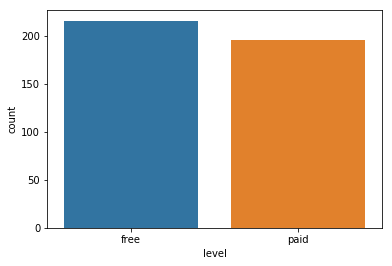

In [44]:
df_pd_level = df_level.select('level').toPandas()
ax = sns.countplot(x='level', data=df_pd_level)

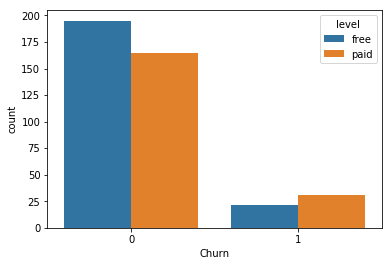

In [45]:
df_pd_churn = df_level.select('level', "Churn").toPandas()
ax = sns.countplot(x='Churn', hue='level', data=df_pd_churn)

We can see that `paid` user has higher churn rate than `free` user.

**Difference between "F" and "M" user in churn rate?**

In [34]:
df_gender = df.select("userId", 'gender', 'Churn').distinct()

In [39]:
# df_pd_gender = df_gender.groupBy('gender').count().toPandas()

# gender = list(df_pd_gender['gender'])
# gender_values = list(df_pd_gender['count'])

# plt.figure(figsize = (6, 6))

# plt.bar(gender, gender_values)

# plt.xlabel("Gender")
# plt.ylabel("No. of user")
# plt.title("Gender of Sparkify user")
# plt.show()

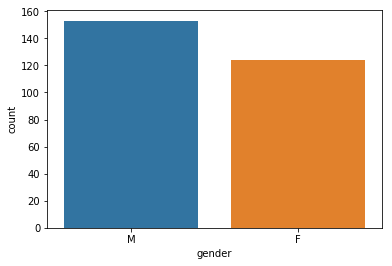

In [42]:
df_pd_gender = df_gender.select('gender').toPandas()
ax = sns.countplot(x='gender', data=df_pd_gender)

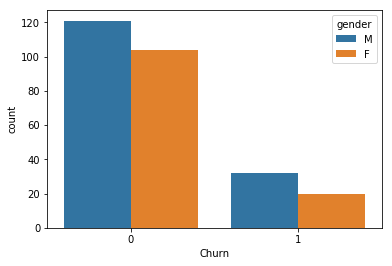

In [40]:
df_pd_churn = df_gender.select('gender', 'Churn').toPandas()
ax = sns.countplot(x='Churn', hue='gender', data=df_pd_churn)

In general, the number of male user is greater than female and this trend remain the same for churn rate.

**What time in a month/year does user cancel the subcription highest?**

In [63]:
df_month = df.select('userId', 'ts', 'Churn')

df_month = df_month.withColumn('ts', F.col('ts')/1000)

df_month = df_month.withColumn('ts', F.to_timestamp(F.col('ts')))

df_month = df_month.withColumn('year', F.year('ts')) \
    .withColumn('month', F.month('ts')) \
    .withColumn('day', F.dayofmonth('ts')) \
    .withColumn('hour', F.hour('ts'))

df_month.show(5)

+------+-------------------+-----+----+-----+---+----+
|userId|                 ts|Churn|year|month|day|hour|
+------+-------------------+-----+----+-----+---+----+
|    30|2018-10-01 00:01:57|    0|2018|   10|  1|   0|
|     9|2018-10-01 00:03:00|    0|2018|   10|  1|   0|
|    30|2018-10-01 00:06:34|    0|2018|   10|  1|   0|
|     9|2018-10-01 00:06:56|    0|2018|   10|  1|   0|
|    30|2018-10-01 00:11:16|    0|2018|   10|  1|   0|
+------+-------------------+-----+----+-----+---+----+
only showing top 5 rows



In [73]:
df_month.groupBy('month').sum('Churn').sort('month').show()

+-----+----------+
|month|sum(Churn)|
+-----+----------+
|   10|        30|
|   11|        22|
|   12|         0|
+-----+----------+



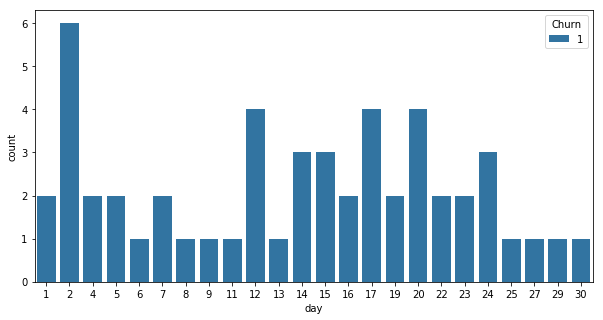

In [79]:
df_pd_month = df_month.filter(F.col('Churn') == 1).toPandas()
plt.figure(figsize = (10, 5))
ax = sns.countplot(x='day', hue='Churn', data=df_pd_month)

The day with highest churn rate is at the begining of the month, which is the 2nd.

**Does user who not very active result in cancellation?**

In [84]:
df_churn_user = df.filter(F.col('Churn') == 1)

df_churn_user = df_churn_user.select(F.col('userId').alias('churn_userId'))

df_churn_log = df.join(
    df_churn_user,
    df.userId == df_churn_user.churn_userId,
    'inner'
).drop('churn_userId')

df_churn_log.show(5)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|num_of_churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+------------+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|NextSong|1533157139000|      174|    paranoid android|   200|1539317144000|"Mozilla/5.0 (Mac...|   125|    0|           0|
|The Notorious B.I.G.|Logged In|    Mason|     M|   

In [85]:
df_churn_log.count()

44864

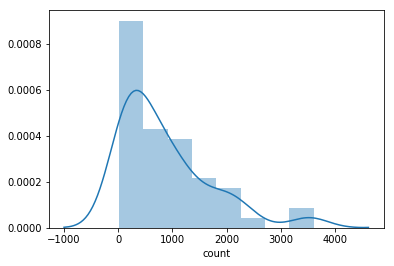

In [93]:
df_pd_dist = df_churn_log.groupBy('userId').count().toPandas()
ax = sns.distplot(df_pd_dist['count'])

The user is not very active before canceling the subcription.

**Does user still use Sparkify after cancel the subcription?**

In [101]:
window = Window.partitionBy("userId").orderBy("ts").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_cancel = df_churn_log.withColumn("max_ts", F.max("ts").over(window))
df_cancel.show(5)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+------------+-------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|num_of_churn|       max_ts|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+------------+-------------+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|NextSong|1533157139000|      174|    paranoid android|   200|1539317144000|"Mozilla/5.0 (Mac...|   125|    0|           0|15393189180

In [102]:
df_cancel = df_cancel.filter(F.col('ts') == F.col('max_ts'))
df_cancel.show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+------------+-------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|num_of_churn|       max_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+------------+-------------+
|  null|Logged In|    Mason|     M|            9|    Hart|  null| free|  Corpus Christi, TX|   PUT|              Cancel|1533157139000|      174|null|   307|1539318918000|"Mozilla/5.0 (Mac...|   125|    0|           0|1539318918000|
|  null|Cancelled|    Mason|     M|           10|    Hart|  null| free| 

In [103]:
df_cancel.select('artist').distinct().collect()

[Row(artist=None)]

After canceled the subcription, no one continue to use the Sparkify.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.